In [46]:
import boto3 as boto3

bucket_name = 'iot-robotdata-noosa'
feature_path = "features/"
remote_path = "test/"
local_path = "s3data/" # what's local path when executing on EMR?
file_list = ["ws_orderinfo_orders_app.csv", "ws_orderinfo_orders_server.csv",\
             "ws_orderinfo_orderinround.csv", "ws_orderinfo_carinfo.csv",\
            "ws_orderinfo_demographic.csv"]

for name in file_list:
    file_name = remote_path + name
    local_file_name = local_path + name
    s3 = boto3.resource('s3')
    s3.Object(bucket_name, file_name).download_file(local_file_name)

In [47]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

df_app = pd.read_csv(local_path+'ws_orderinfo_orders_app.csv', header=0)
df_server = pd.read_csv(local_path+'ws_orderinfo_orders_server.csv', header=0)
# df_server = df2[["OrderID", "orderdate", "tokendate","shipdate"]]
df_round = pd.read_csv(local_path+'ws_orderinfo_orderinround.csv', header=0)
df_car = pd.read_csv(local_path+'ws_orderinfo_carinfo.csv', header=0)

In [48]:
# filtered_df = df[df['orderdate'].isnull()]
df_server = df_server.dropna()
df_server["orderdate"] = df_server["orderdate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_server["tokendate"] = df_server["tokendate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_server["shipdate"] = df_server["shipdate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df_server["transitDuration"] = (df_server["shipdate"]-df_server["tokendate"])/ np.timedelta64(1, 's')
df_server["fulfillDuration"] = (df_server["shipdate"]-df_server["orderdate"])/ np.timedelta64(1, 's')

df_server["amount"] = df_server["red"]+df_server["blue"]+df_server["yellow"]+df_server["black"]+df_server["white"]

## Features: K-means & HCA

### Add user info to orders

In [49]:
dic = {}

# Combine with customer info
df_user = pd.read_csv(local_path+'ws_orderinfo_demographic.csv', header=0)
df_user_server = pd.merge(df_server, df_user, how='inner', left_on="customer", right_on="name")
df_user_server = df_user_server.drop(columns=['name','orderdate','tokendate','shipdate', 'id','entryid'])
for key in ["customer","age", "sex", "city", "state", "country",\
                 "income", "credit","education", "occupation"]:
    dic[key] = {}
    ## Add Customer ID (Integer number)
    id = 1
    for _,name in df_user_server[[key]].drop_duplicates()[key].iteritems():
        dic[key][name] = id # id starts from 0
        id = id+1
    df_user_server[key] = df_user_server[key].apply(lambda x: dic[key][x])

    
print "dictionary keys:",dic.keys()
print df_user_server.info()

dictionary keys: ['customer', 'city', 'country', 'age', 'sex', 'credit', 'state', 'income', 'education', 'occupation']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 21 columns):
customer           150 non-null int64
red                150 non-null int64
blue               150 non-null int64
green              150 non-null int64
yellow             150 non-null int64
black              150 non-null int64
white              150 non-null int64
pending            150 non-null int64
shipped            150 non-null int64
transitDuration    150 non-null float64
fulfillDuration    150 non-null float64
amount             150 non-null int64
age                150 non-null int64
sex                150 non-null int64
city               150 non-null int64
state              150 non-null int64
country            150 non-null int64
income             150 non-null int64
credit             150 non-null int64
education          150 non-null int64
occupation  

### Standardize & PCA 

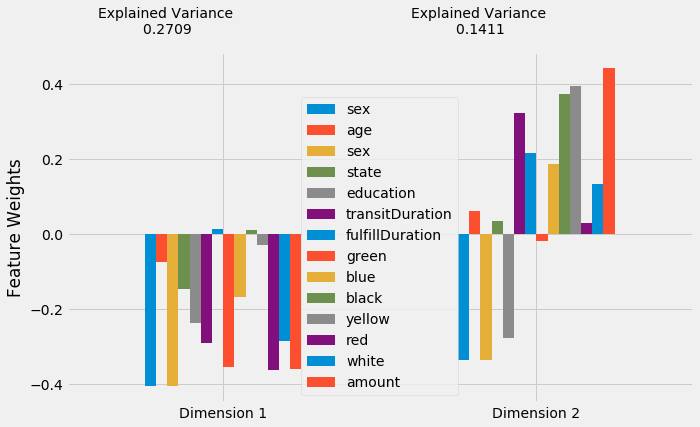

In [50]:
import visuals as vs
import numpy as np
index = ["sex", "age", "sex", "state", "education",\
         "transitDuration","fulfillDuration", \
         "green","blue","black","yellow","red","white","amount",\
         
        ]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pca_result = scaler.fit_transform(df_user_server[index].values)

pca = PCA(n_components=2)
pca_result= pca.fit_transform(pca_result)

pca_summary = vs.pca_results(df_user_server[index], pca)

np.savetxt(feature_path + "pca.csv", pca_result, delimiter=",")

## Features: Linear Regression

In [51]:
countSplit = [];  # countSplit[0]: number of being split of order 1

for k in xrange(1, len(df_server)+1):
    cluster = [i for i in xrange(len(df_server)) if df_round["orderid"][i]==k]
    countSplit.append(len(cluster))
    
df_server["split"] = df_server["id"].apply(lambda id: countSplit[id-1])

df_car["entermaintence"] = df_car["entermaintence"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_car["exitmaintence"] = df_car["exitmaintence"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_car["maintainDuration"] = (df_car["exitmaintence"]-df_car["entermaintence"])/ np.timedelta64(1, 's')
df_car = df_car[["roundid","maintainDuration"]]
df_app = pd.merge(df_app, df_car, how='left', left_on="id", right_on="roundid")

import numpy as np

df_app.fillna(0)
df_app.fillna(0)

,id,carid,red,blue,green,yellow,black,white,arriveAtReceiving,loadedDate,arriveAtShipping,unloadedDate,roundid,maintainDuration
0,1,4,0.0,5.0,3.0,7.0,9.0,0.0,2018-07-22 15:01:08,2018-07-22 15:02:03,2018-07-22 15:02:28,2018-07-22 15:02:45,1.0,11.0
1,2,12,7.0,0.0,4.0,9.0,0.0,4.0,2018-07-22 15:02:09,2018-07-22 15:02:43,2018-07-22 15:02:57,2018-07-22 15:03:54,0.0,0.0
2,3,4,0.0,4.0,4.0,2.0,9.0,5.0,2018-07-22 15:03:25,2018-07-22 15:04:00,2018-07-22 15:04:25,2018-07-22 15:05:22,0.0,0.0
3,4,12,1.0,4.0,6.0,7.0,6.0,0.0,2018-07-22 15:04:08,2018-07-22 15:05:04,2018-07-22 15:05:29,2018-07-22 15:06:19,0.0,0.0
4,5,4,9.0,1.0,6.0,0.0,3.0,5.0,2018-07-22 15:05:39,2018-07-22 15:06:29,2018-07-22 15:06:42,2018-07-22 15:07:35,0.0,0.0
5,6,12,8.0,1.0,4.0,1.0,7.0,3.0,2018-07-22 15:06:33,2018-07-22 15:07:18,2018-07-22 15:07:39,2018-07-22 15:08:27,0.0,0.0
6,7,4,8.0,4.0,2.0,1.0,5.0,4.0,2018-07-22 15:07:46,2018-07-22 15:08:39,2018-07-22 15:08:51,2018-07-22 15:09:45,0.0,0.0
7,8,12,4.0,1.0,4.0,2.0,8.0,5.0,2018-07-22 15:08:44,2018-07-22 15:09:29,2018-07-22 15:09:51,2018-07-22 15:10:42,0.0,0.0
8,9,4,0.0,9.0,5.0,1.0,4.0,5.0,2018-07-22 15:09:58,2018-07-22 15:10:39,2018-07-22 15:10:54,2018-07-22 15:11:38,9.0,8.0
9,10,12,2.0,4.0,2.0,0.0,11.0,5.0,2018-07-22 15:10:56,2018-07-22 15:11:51,2018-07-22 15:12:18,2018-07-22 15:12:58,0.0,0.0


In [52]:
df_app_4= df_app.iloc[[i for i in xrange(len(df_app)) if df_app["carid"][i]==4]][["id","maintainDuration"]]
df_app_12= df_app.iloc[[i for i in xrange(len(df_app)) if df_app["carid"][i]==12]][["id","maintainDuration"]]
# df_app = df_app[["id","maintainDuration"]]
df_round = pd.merge(df_round, df_app[["id","carid"]], how='left', left_on="roundid", right_on="id", suffixes = ["",""])
df_round = df_round[["roundid","orderid","carid"]]

time = 0
count = 1
for index, row in df_app_4.iterrows():
    if np.isnan(row["maintainDuration"]):
        df_app_4["maintainDuration"][index] = time / count
    else:
        time = time + row["maintainDuration"]
        df_app_4["maintainDuration"][index] = time / count
        count = count+1
        
    df_app["maintainDuration"][int(row["id"]-1)] = df_app_4["maintainDuration"][index]
    
time = 0
count = 1
for index, row in df_app_12.iterrows():
    if np.isnan(row["maintainDuration"]):
        df_app_12["maintainDuration"][index] = time / count
    else:
        time = time + row["maintainDuration"]
        df_app_12["maintainDuration"][index] = time / count
        count = count+1
        
    df_app["maintainDuration"][int(row["id"]-1)] = df_app_12["maintainDuration"][index]

c:\python27\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\python27\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\python27\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [53]:
df_server["maintain4"] = 0.0
df_server["maintain12"] = 0.0

order2round = {}

for i in xrange(len(df_round)):
    if not order2round.has_key(int(df_round["orderid"][i])-1):
        order2round[int(df_round["orderid"][i])-1] = []
        
    order2round[int(df_round["orderid"][i])-1].append(int(df_round["roundid"][i])-1)
    
for i in xrange(len(df_server)):
    if not order2round.has_key(df_server["id"][i]):
        continue
    rounds = order2round[df_server["id"][i]]
    for r in rounds:
        if df_app["carid"][r]==4:
            df_server["maintain4"][i] =  df_app["maintainDuration"][r]
        else:
            df_server["maintain12"][i] =  df_app["maintainDuration"][r]
            
df_server.to_csv(path_or_buf = feature_path + "regression")

c:\python27\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
